## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI3D-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'ada'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
ada_wavelet_full_syntheticMRI3D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/ada'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 0, 3: 564, 4: 22538, 5: 296776, 6: 2880648, 7: 25362406, 8: 213093688}

Running 12760 CDFs


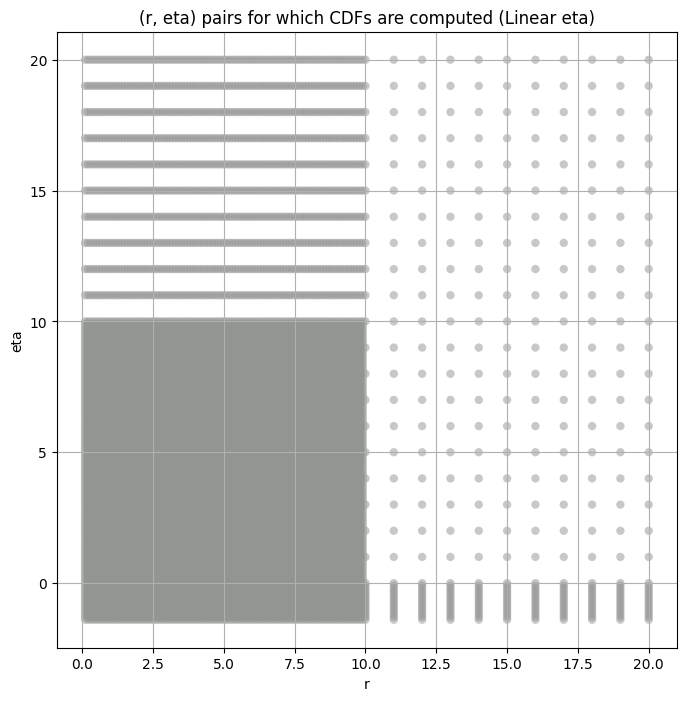

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2               NaN           NaN           NaN        NaN         NaN   
3      1.917588e+06  1.678674e+06  2.165048e+06  -0.628360   -0.869535   
4      8.142820e+05  7.775826e+05  8.514975e+05   1.116847    0.878992   
5      2.493660e+05  2.319150e+05  2.677669e+05   5.788045    4.961286   
6      4.386916e+04  4.057316e+04  4.733290e+04   6.932356    5.826878   
7      6.100906e+03  5.614957e+03  6.619654e+03   8.188866    6.884765   
8      4.320266e+02  3.940085e+02  4.756335e+02  11.321023    7.565761   

       kurt_upper  total_samples  
layer                             
2             NaN            0.0  
3       -0.348175          564.0  
4        1.405564        22538.0  
5        6.675331       296776.0  
6        8.281218      2880648.0  
7        9.728744     25362406.0  
8       25.109600    213093688.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2               NaN            NaN             NaN             NaN   
3      1.917588e+06   1.917588e+06    1.373559e+06    1.064545e+06   
4      8.142820e+05   8.142820e+05    7.885167e+05    7.707798e+05   
5      2.493660e+05   2.493660e+05    2.445011e+05    2.405295e+05   
6      4.386916e+04   4.386916e+04    4.283417e+04    4.205356e+04   
7      6.100906e+03   6.100906e+03    5.941467e+03    5.822539e+03   
8      4.320266e+02   4.320266e+02    4.151963e+02    4.050721e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3       837364.562500    670261.125000    378513.156250    180533.687500   
4       754864.562500    740214.937500    713670.812500    690427.187500   
5       236914.359375    233617.781250    227561.953125    222069.203125   
6        41367.351562     40740.335938     39616.093750     38615.246094   
7         5719.368164      5625.776367      5458.166016      5309.066895   
8          396.726074       389.429352       376.816406       365.939270   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3         37916.554688              NaN              NaN              NaN  
4        669259.062500    649395.375000    630650.875000    579758.500000  
5        217009.109375    212313.671875    207935.250000    196275.890625  
6         37705.695312     36866.226562     36083.039062     34000.535156  
7          5173.525879      5048.682617      4932.733398      4625.627930  
8           356.261780       347.490540       339.435394       318.439941

####
Layer  2
####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.053007183783921275 1917588.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.08029443996233299 1373558.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.10790941109078467 1064545.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.13541855074279355 837364.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.16174506539113864 670261.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.22864790761195297 378513.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.2988503245728191 180533.69


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.40490430305921177 37916.555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 nan nan
Number of samples: 564, Without approximation : 564.0


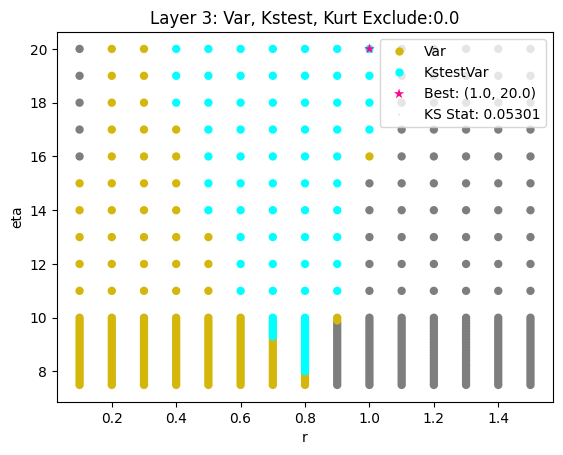

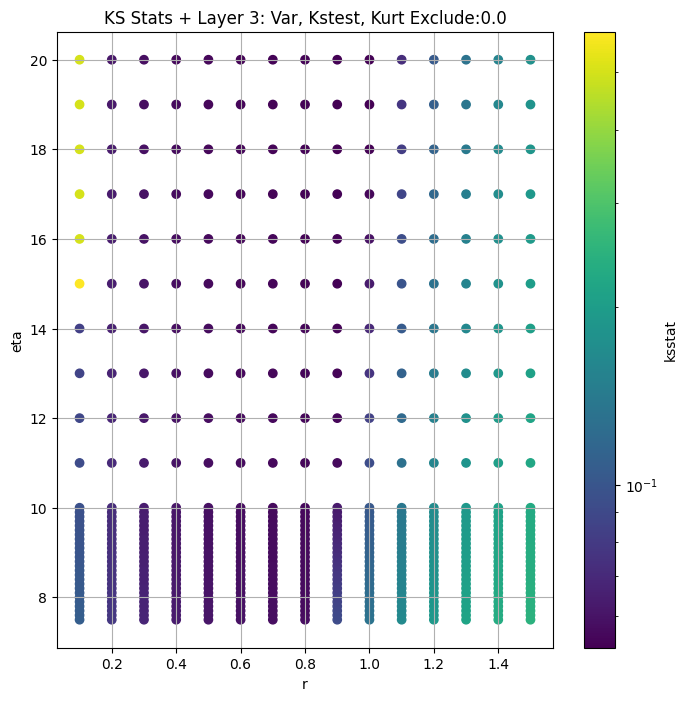

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.01690054901124724 814282.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.018468693675628242 788516.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.01946486990613354 770779.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.020455694285224965 754864.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.0214590288938747 740214.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.023135458298331413 713670.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.024803538343518297 690427.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.026429136563664857 669259.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.028088298341952547 649395.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.02972703276162547 630650.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.03501319970123162 579758.5
Number of samples: 22538, Without approximation : 22538.0


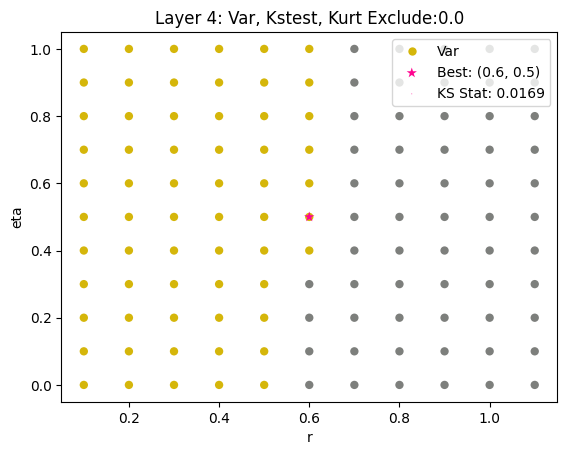

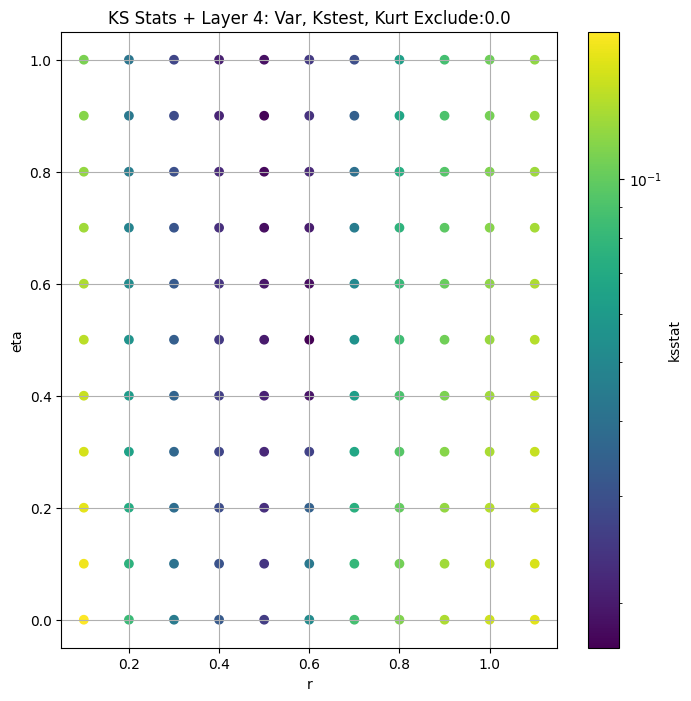

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.004975092206401105 249365.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.00452790211367865 244501.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.00413433675550734 240529.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.003617114268879465 236914.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.0035158771189835736 233617.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0037342158339820353 227561.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.004232534530860102 222069.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.0047335194943616266 217009.11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.005228150551244979 212313.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.005722258878939068 207935.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.007240152196407945 196275.89
Number of samples: 100000, Without approximation : 296776.0


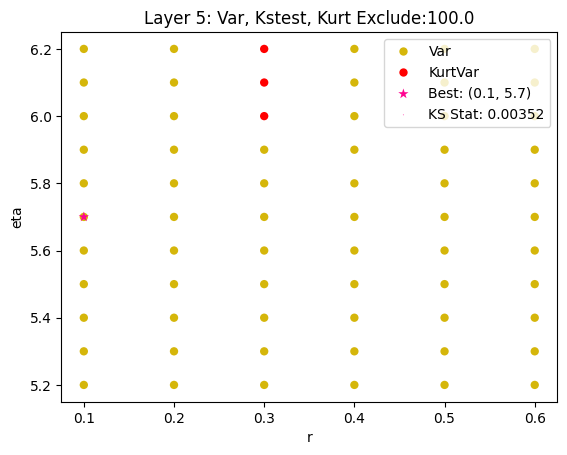

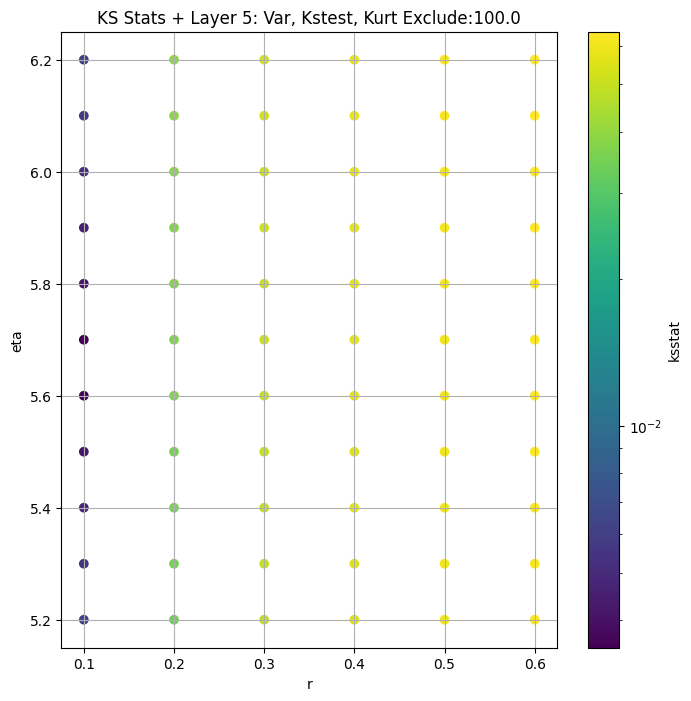

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.0031017063915744214 43869.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.003319580096689645 42834.17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.003564805706937013 42053.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.004108155411701286 41367.35


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.00421481645697672 40740.336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.004638216631590867 39616.094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.005139627447668604 38615.246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.005744298735029019 37705.695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.0062181627476820545 36866.227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.00669161330764112 36083.04


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.008433019005885889 34000.535
Number of samples: 100000, Without approximation : 2880648.0


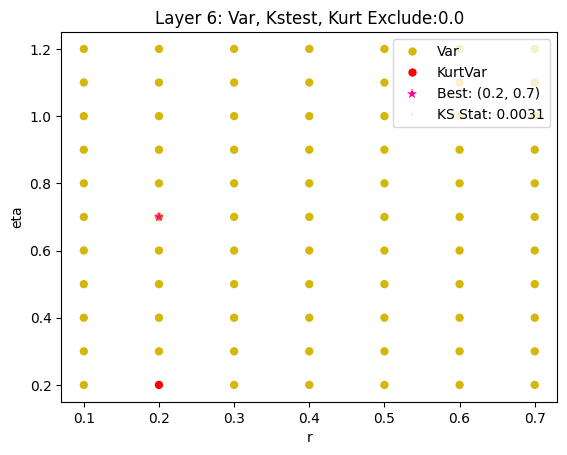

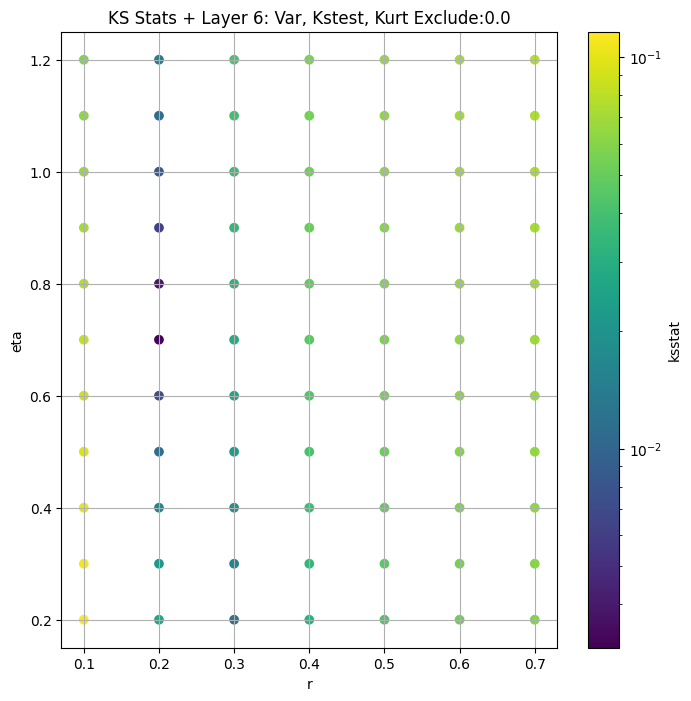

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.004269236934963727 6100.906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.0037855075815779182 5941.467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.004594977451681248 5822.5386


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.005026558075892931 5719.368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.00444324686655357 5625.7764


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.00514771143520909 5458.166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.005881716435075117 5309.067


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.00622803231869018 5173.526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.006823385698927487 5048.6826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.007379111602382832 4932.7334


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.008786470161132525 4625.628
Number of samples: 100000, Without approximation : 25362406.0


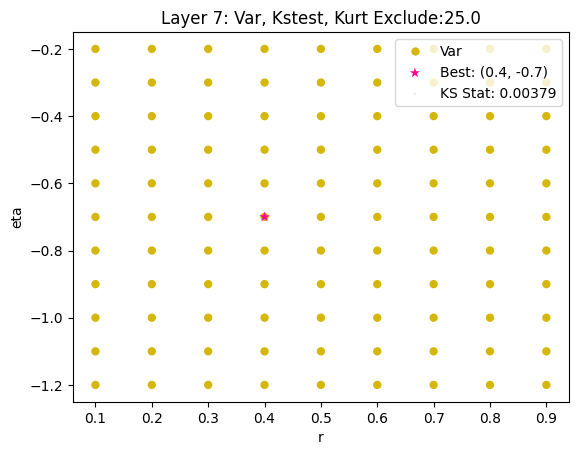

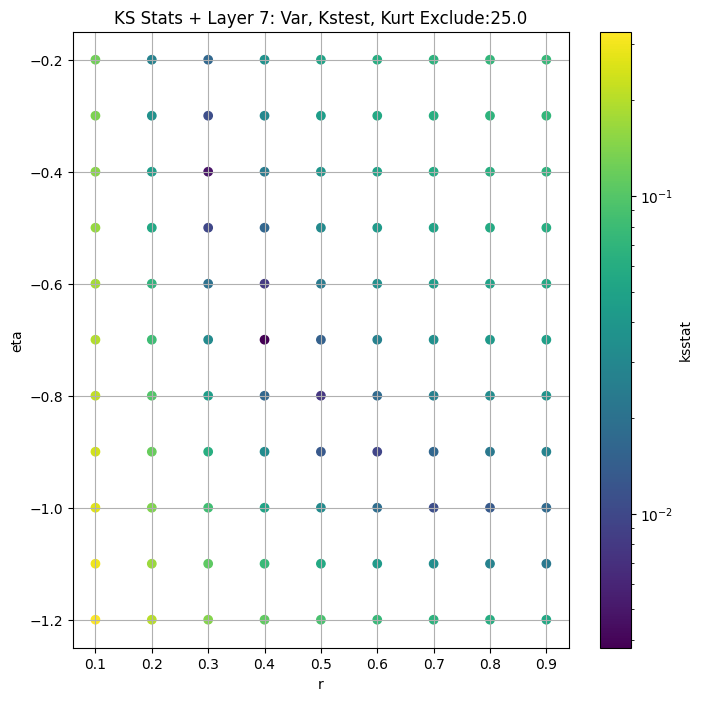

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0032252226419142993 432.0266


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0035939653822714135 415.1963


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.003927222088184142 405.07214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.004584532001719377 396.72607


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005184110636761191 389.42935


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.004818418321112405 376.8164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.005674089732952831 365.93927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.006494279276559989 356.26178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.00692988220665347 347.49054


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007627901866754258 339.4354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008979776110623172 318.43994
Number of samples: 100000, Without approximation : 213093688.0


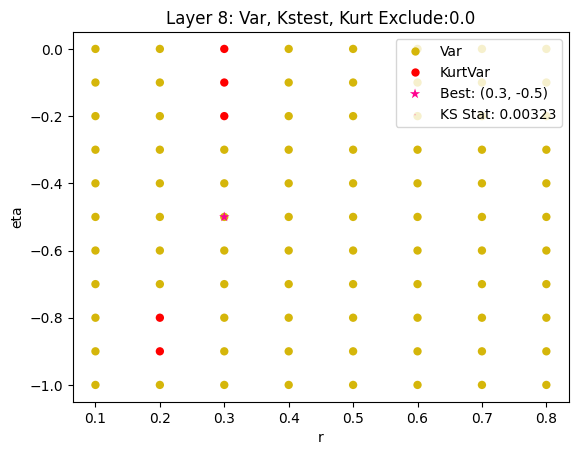

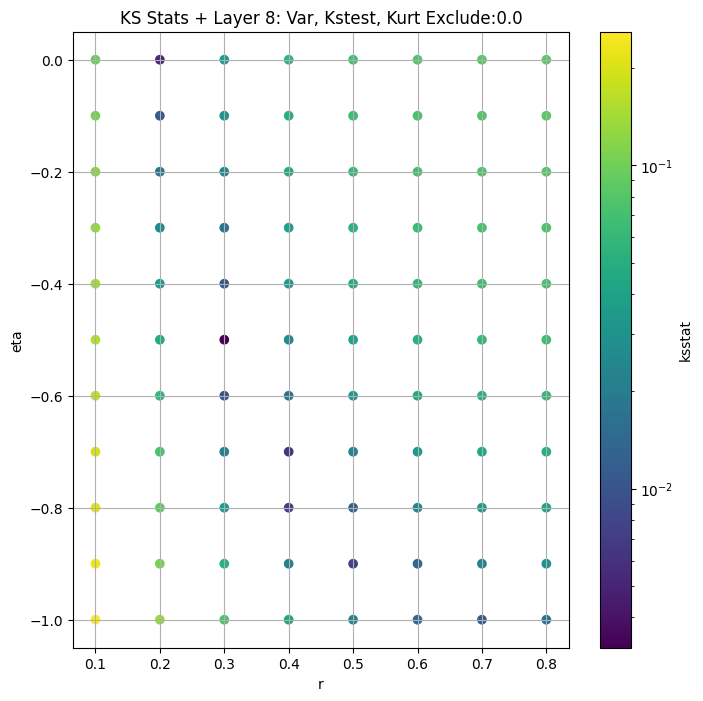

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2               NaN           NaN           NaN        NaN         NaN   
3      1.917588e+06  1.678674e+06  2.165048e+06  -0.628360   -0.869535   
4      8.142820e+05  7.775826e+05  8.514975e+05   1.116847    0.878992   
5      2.493660e+05  2.319150e+05  2.677669e+05   5.788045    4.961286   
6      4.386916e+04  4.057316e+04  4.733290e+04   6.932356    5.826878   
7      6.100906e+03  5.614957e+03  6.619654e+03   8.188866    6.884765   
8      4.320266e+02  3.940085e+02  4.756335e+02  11.321023    7.565761   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            0.0                  NaN        NaN          NaN   
3       -0.348175          564.0             0.053007        1.0         20.0   
4        1.405564        22538.0             0.016901        0.6          0.5   
5        6.675331       296776.0             0.003516        0.1          5.7   
6        8.281218      2880648.0             0.003102        0.2          0.7   
7        9.728744     25362406.0             0.003786        0.4         -0.7   
8       25.109600    213093688.0             0.003225        0.3         -0.5   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2                NaN                     NaN                 NaN   
3       8.919016e+04                     0.0        1.917588e+06   
4       9.425852e+04                     0.0        8.142820e+05   
5       3.427335e-14                   100.0        2.336178e+05   
6       1.217370e-01                     0.0        4.386916e+04   
7       5.107983e+02                    25.0        5.941467e+03   
8       3.085169e+00                     0.0        4.320266e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                          NaN  
3                     0.056882  
4                     0.009039  
5                     0.002492  
6                     0.000800  
7                     0.000270  
8                     0.000093

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.1617168583804892, var: 670261.125


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.13540087381854307, var: 837364.5625


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.10788797637006187, var: 1064545.125


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.08024432679301985, var: 1373558.75


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.05296754546442084, var: 1917588.375
Number of samples: 564, Without approximation : 564.0


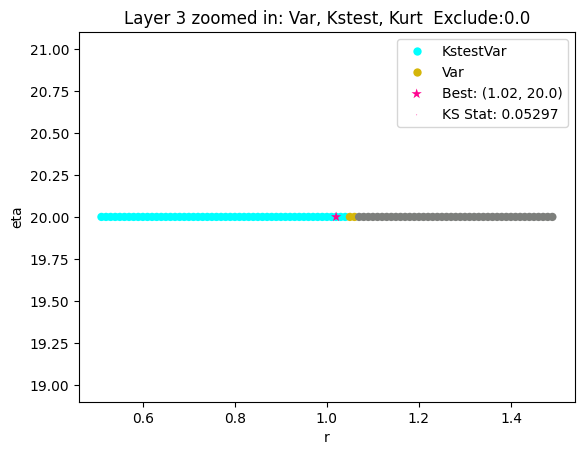

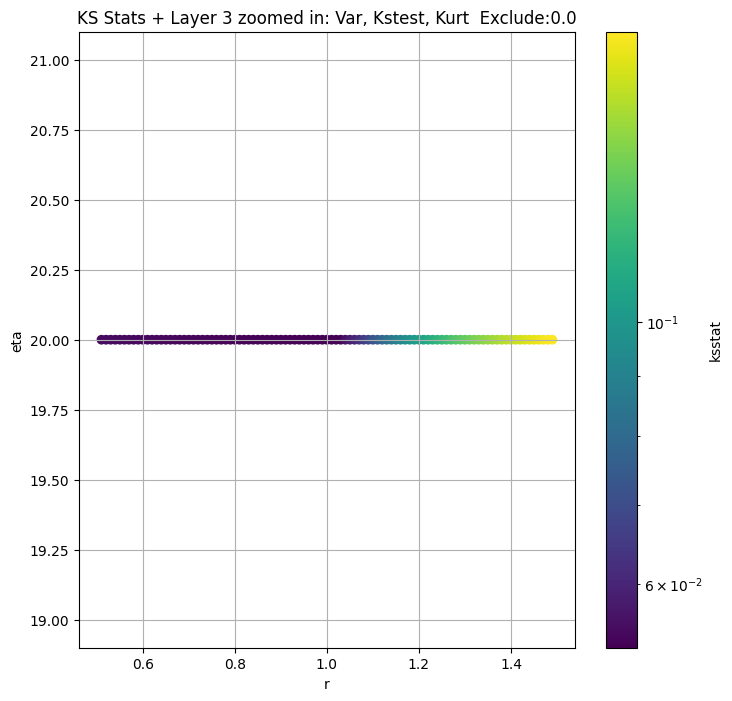

Layer 4


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.021795289154578623, var: 740214.9375


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.020193865431009872, var: 754864.5625


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.01932204675783092, var: 770779.75


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.018267554402235223, var: 788516.6875


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.01690054901124724, var: 814282.0
Number of samples: 22538, Without approximation : 22538.0


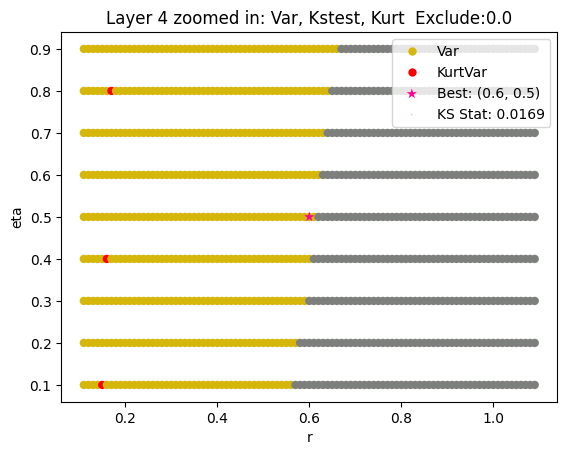

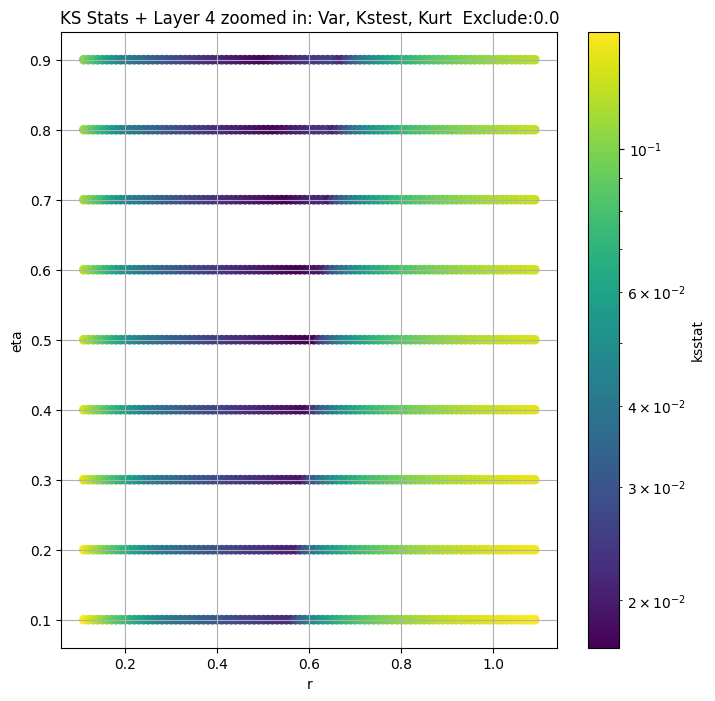

Layer 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 100.0 + 100 = 200, ksstat: 0.004255756405972533, var: 222069.203125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 100.0 + 75 = 175, ksstat: 0.004007836813960219, var: 224754.296875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 100.0 + 50 = 150, ksstat: 0.0037342158339820353, var: 227561.953125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 100.0 + 25 = 125, ksstat: 0.003498533031472295, var: 230504.234375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 100.0 + 0 = 100, ksstat: 0.0035158771189835736, var: 233617.78125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 100.0 + -25 = 75, ksstat: 0.003617114268879465, var: 236914.359375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 100.0 + -50 = 50, ksstat: 0.003928579902371054, var: 240529.46875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 100.0 + -75 = 25, ksstat: 0.004419999591673052, var: 244501.140625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 100.0 + -100 = 0, ksstat: 0.004822361328893354, var: 249365.953125
Number of samples: 100000, Without approximation : 296776.0


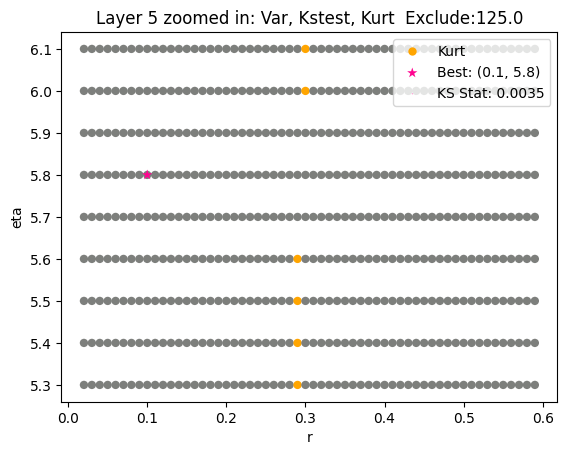

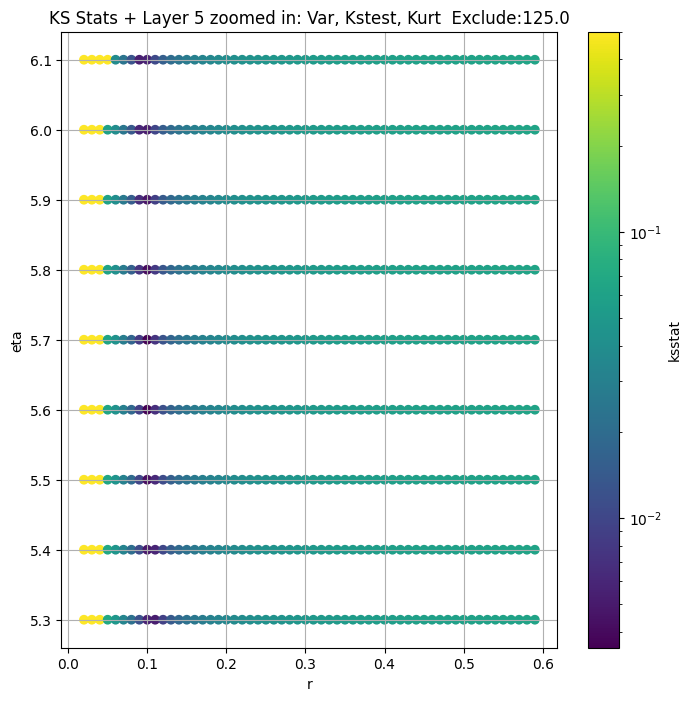

Layer 6


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.0042390609688439905, var: 40740.3359375


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.0038787008712591886, var: 41367.3515625


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.003512244250763609, var: 42053.55859375


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.003134607550812754, var: 42834.171875


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.002768029964078933, var: 43869.16015625
Number of samples: 100000, Without approximation : 2880648.0


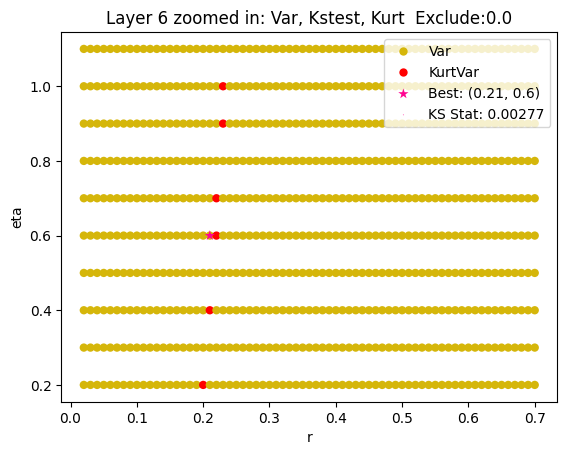

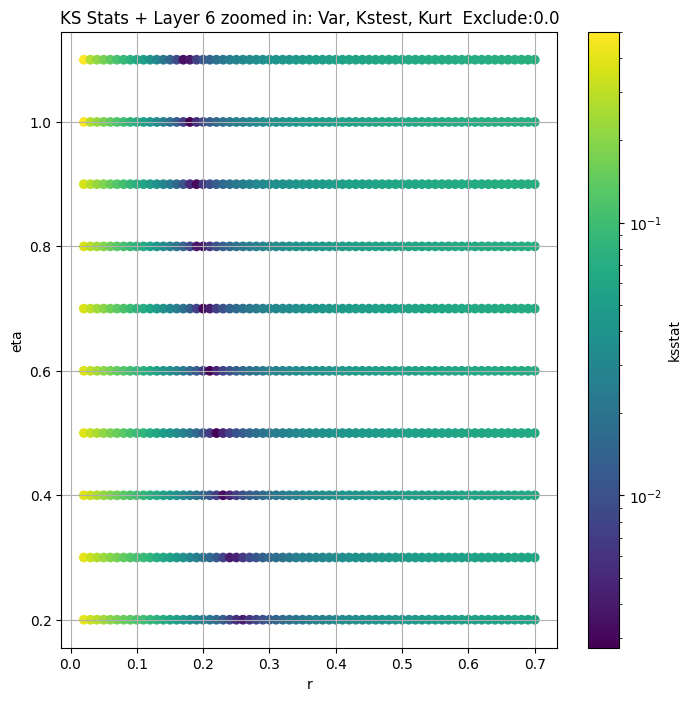

Layer 7


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.004796804046010381, var: 5539.18701171875


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.00441428581049963, var: 5625.7763671875


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.0040235042718469935, var: 5719.3681640625


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.003894639127016413, var: 5822.53857421875


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.0034925244379408957, var: 5941.466796875


  0%|          | 0/1600 [00:00<?, ?it/s]

Finding Minimum after computing 1600 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.0031323200848383005, var: 6100.90576171875
Number of samples: 100000, Without approximation : 25362406.0


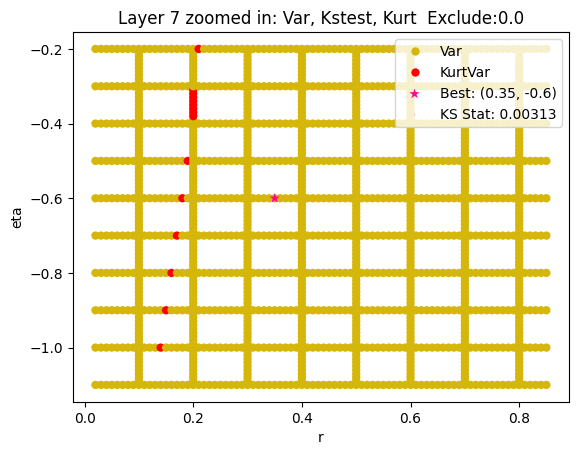

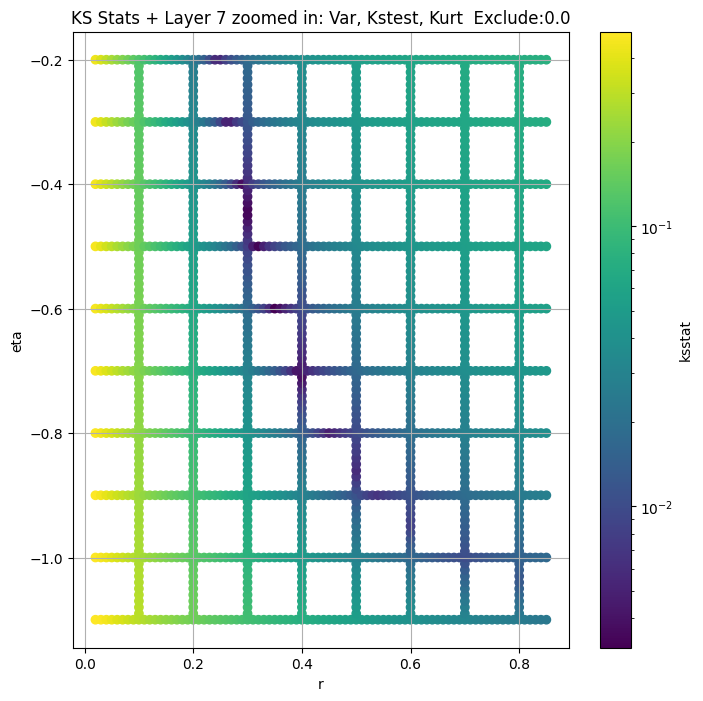

Layer 8


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.004333098893274878, var: 389.4293518066406


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.0038174755501103608, var: 396.72607421875


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.0034865731814808093, var: 405.0721435546875


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.0032130766050393403, var: 415.1962890625


  0%|          | 0/1332 [00:00<?, ?it/s]

Finding Minimum after computing 1332 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.0024898829926881527, var: 432.026611328125
Number of samples: 100000, Without approximation : 213093688.0


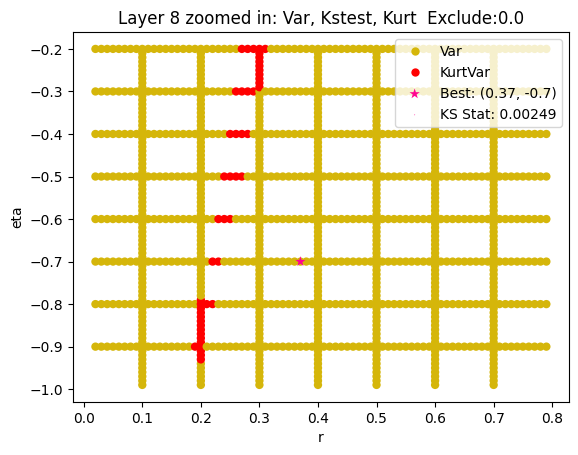

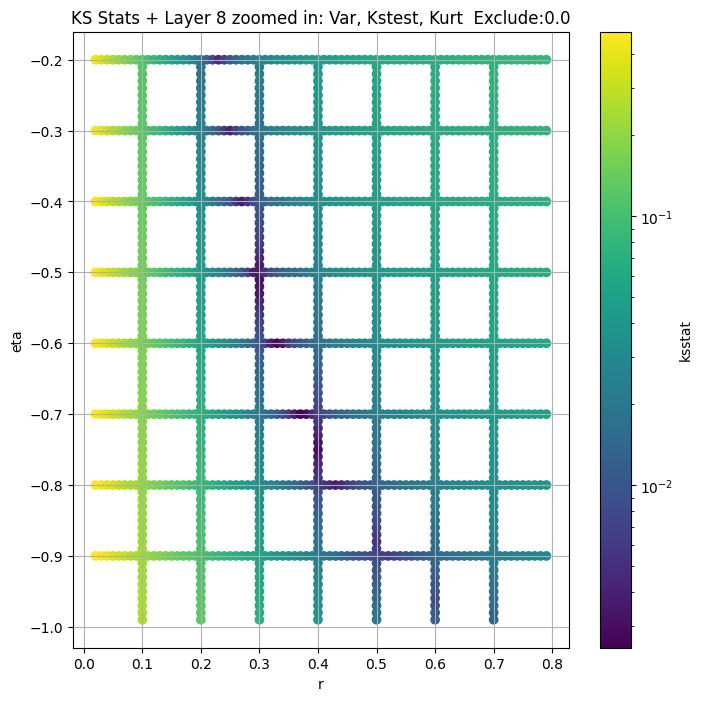

Cannot compute pval with ksstat : nan, n : 0.0


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2               NaN           NaN           NaN        NaN         NaN   
3      1.917588e+06  1.678674e+06  2.165048e+06  -0.628360   -0.869535   
4      8.142820e+05  7.775826e+05  8.514975e+05   1.116847    0.878992   
5      2.493660e+05  2.319150e+05  2.677669e+05   5.788045    4.961286   
6      4.386916e+04  4.057316e+04  4.733290e+04   6.932356    5.826878   
7      6.100906e+03  5.614957e+03  6.619654e+03   8.188866    6.884765   
8      4.320266e+02  3.940085e+02  4.756335e+02  11.321023    7.565761   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            0.0                  NaN        NaN          NaN   
3       -0.348175          564.0             0.053007        1.0         20.0   
4        1.405564        22538.0             0.016901        0.6          0.5   
5        6.675331       296776.0             0.003516        0.1          5.7   
6        8.281218      2880648.0             0.003102        0.2          0.7   
7        9.728744     25362406.0             0.003786        0.4         -0.7   
8       25.109600    213093688.0             0.003225        0.3         -0.5   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2                NaN                     NaN                 NaN   
3       8.919016e+04                     0.0        1.917588e+06   
4       9.425852e+04                     0.0        8.142820e+05   
5       3.427335e-14                   100.0        2.305042e+05   
6       1.217370e-01                     0.0        4.386916e+04   
7       5.107983e+02                    25.0        6.100906e+03   
8       3.085169e+00                     0.0        4.320266e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                          NaN               NaN     NaN       NaN   
3                     0.056882          0.052968    1.02      20.0   
4                     0.009039          0.016901    0.60       0.5   
5                     0.002492          0.003499    0.10       5.8   
6                     0.000800          0.002768    0.21       0.6   
7                     0.000270          0.003132    0.35      -0.6   
8                     0.000093          0.002490    0.37      -0.7   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2               NaN                  NaN           -1  
3      9.662094e+04                  0.0          634  
4      9.425852e+04                  0.0         6337  
5      2.969260e-14                125.0       148388  
6      3.445065e-01                  0.0       243324  
7      1.829277e+02                  0.0       198143  
8      2.377625e+01                  0.0       312148

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

> In quadgk/vadapt (line 278)
In quadgk (line 204)
In compute_cdf_using_gengamma_with_scale (line 10)


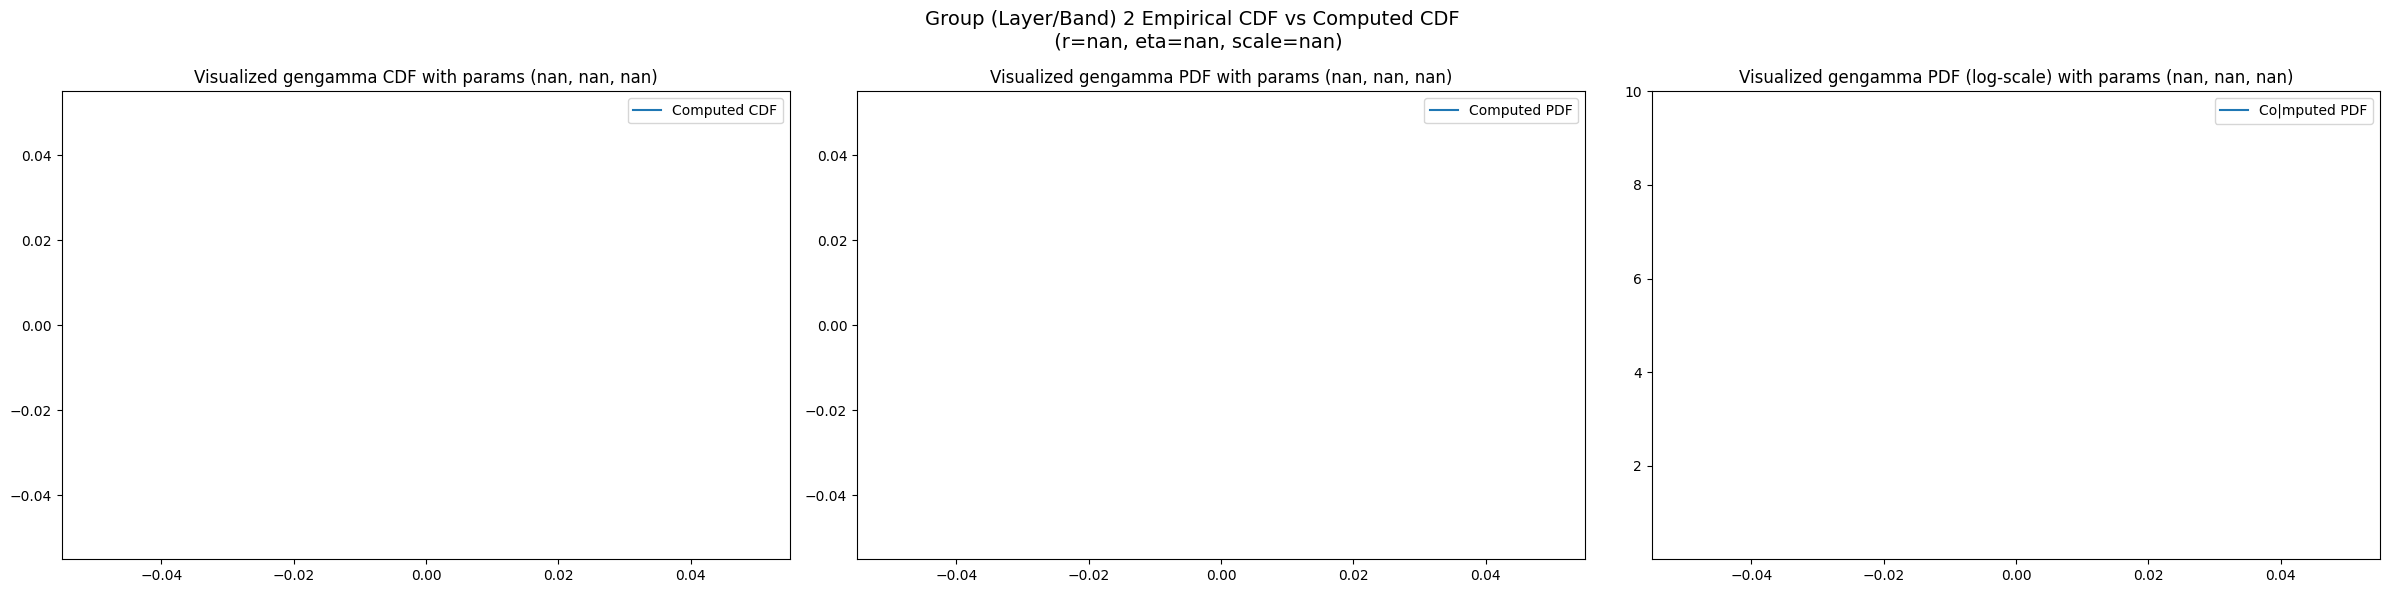

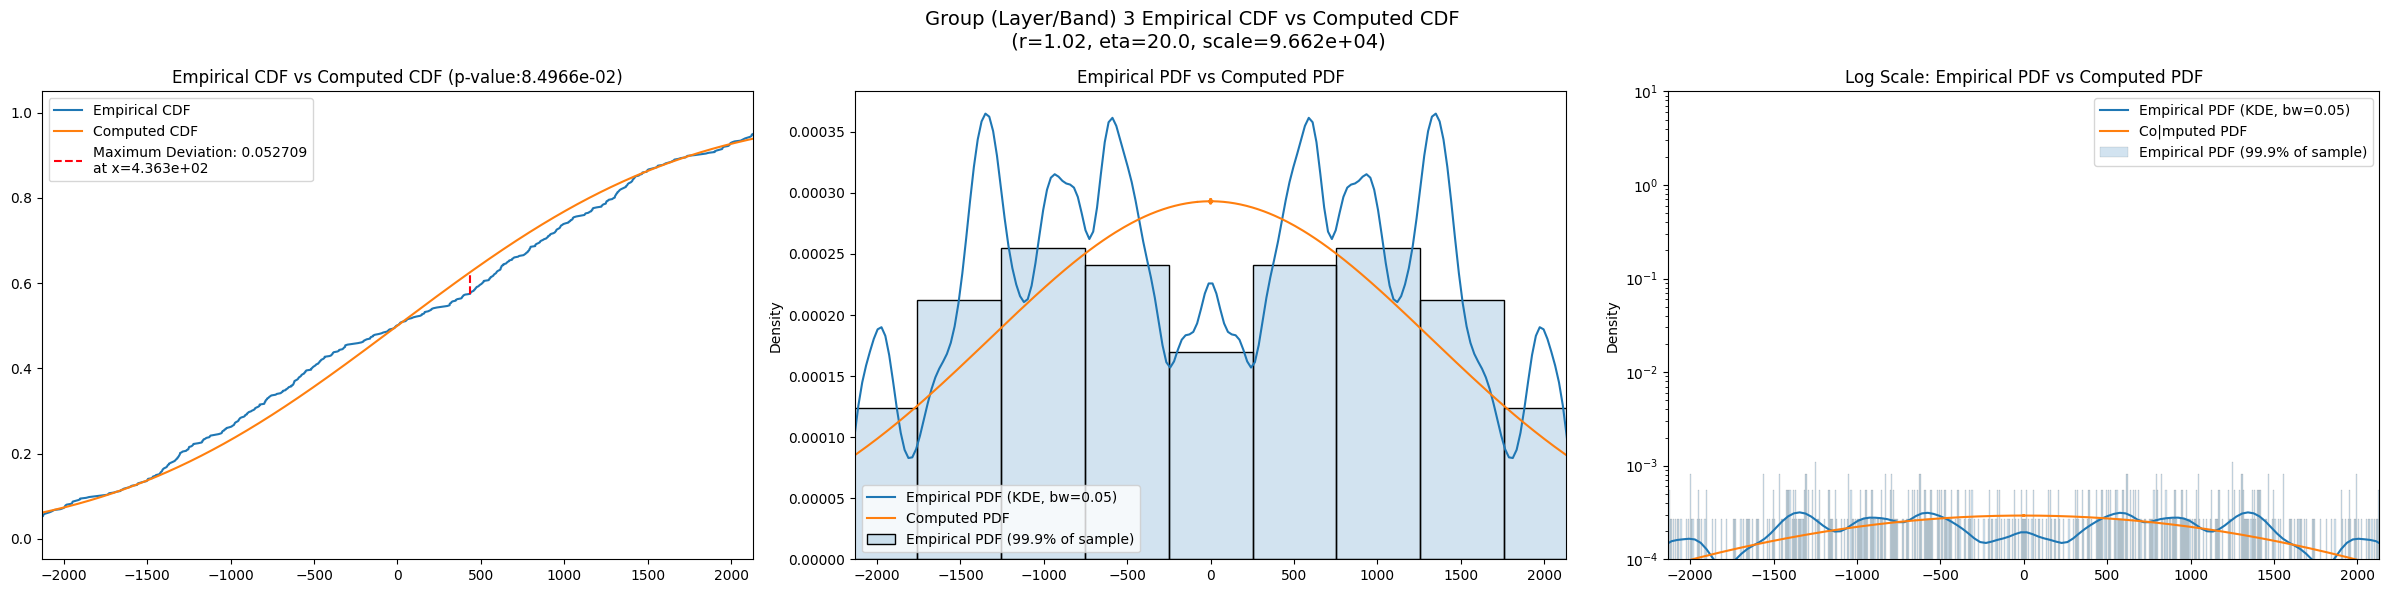

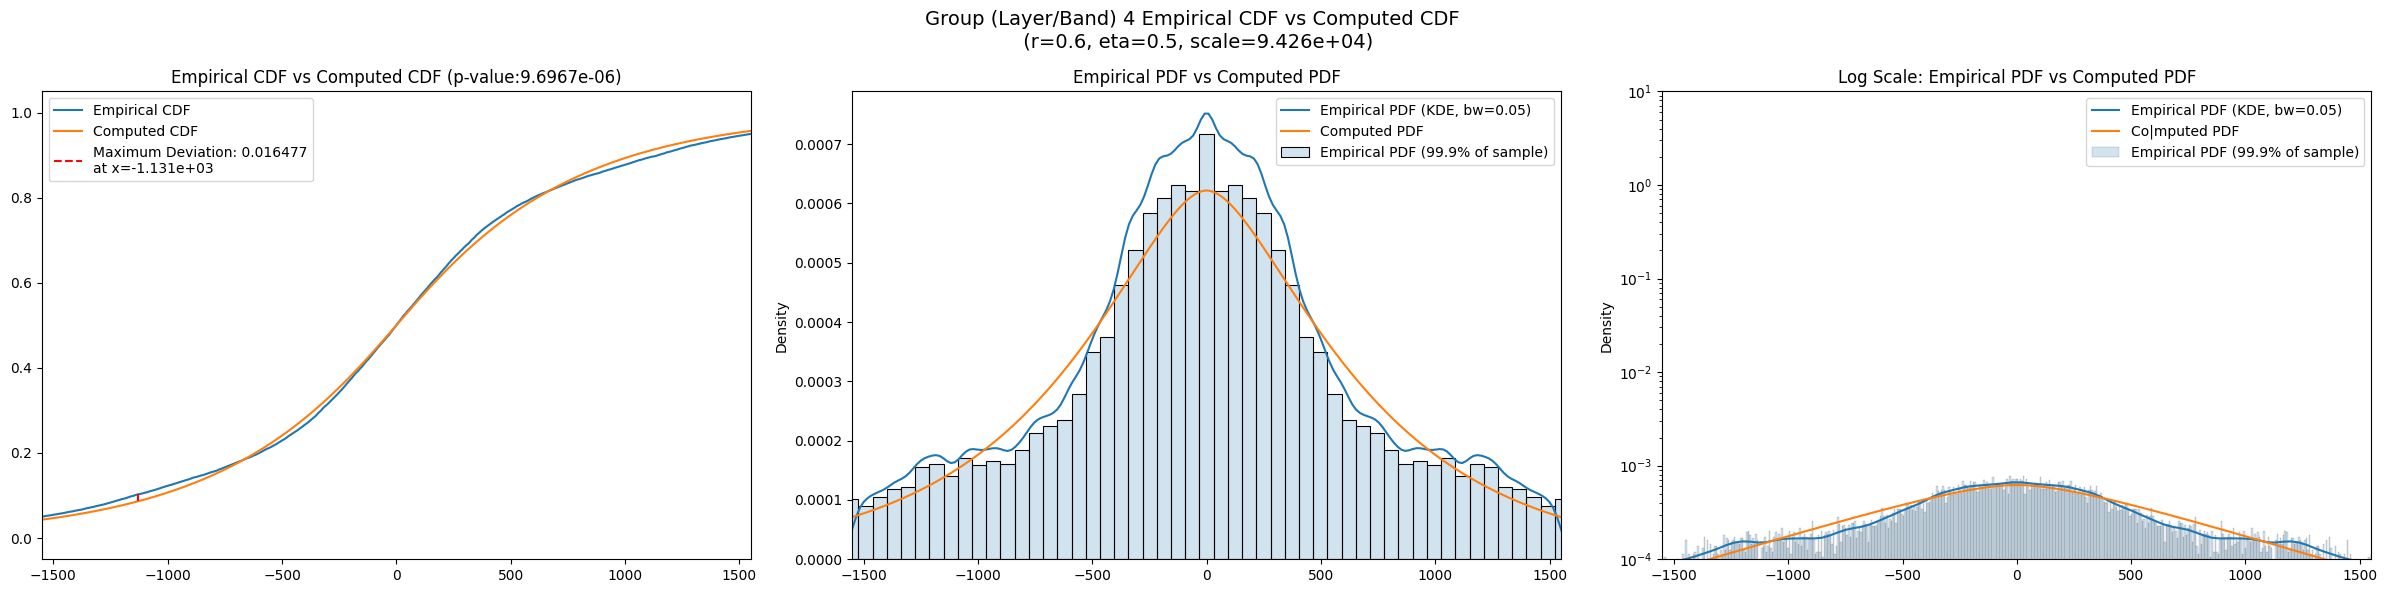

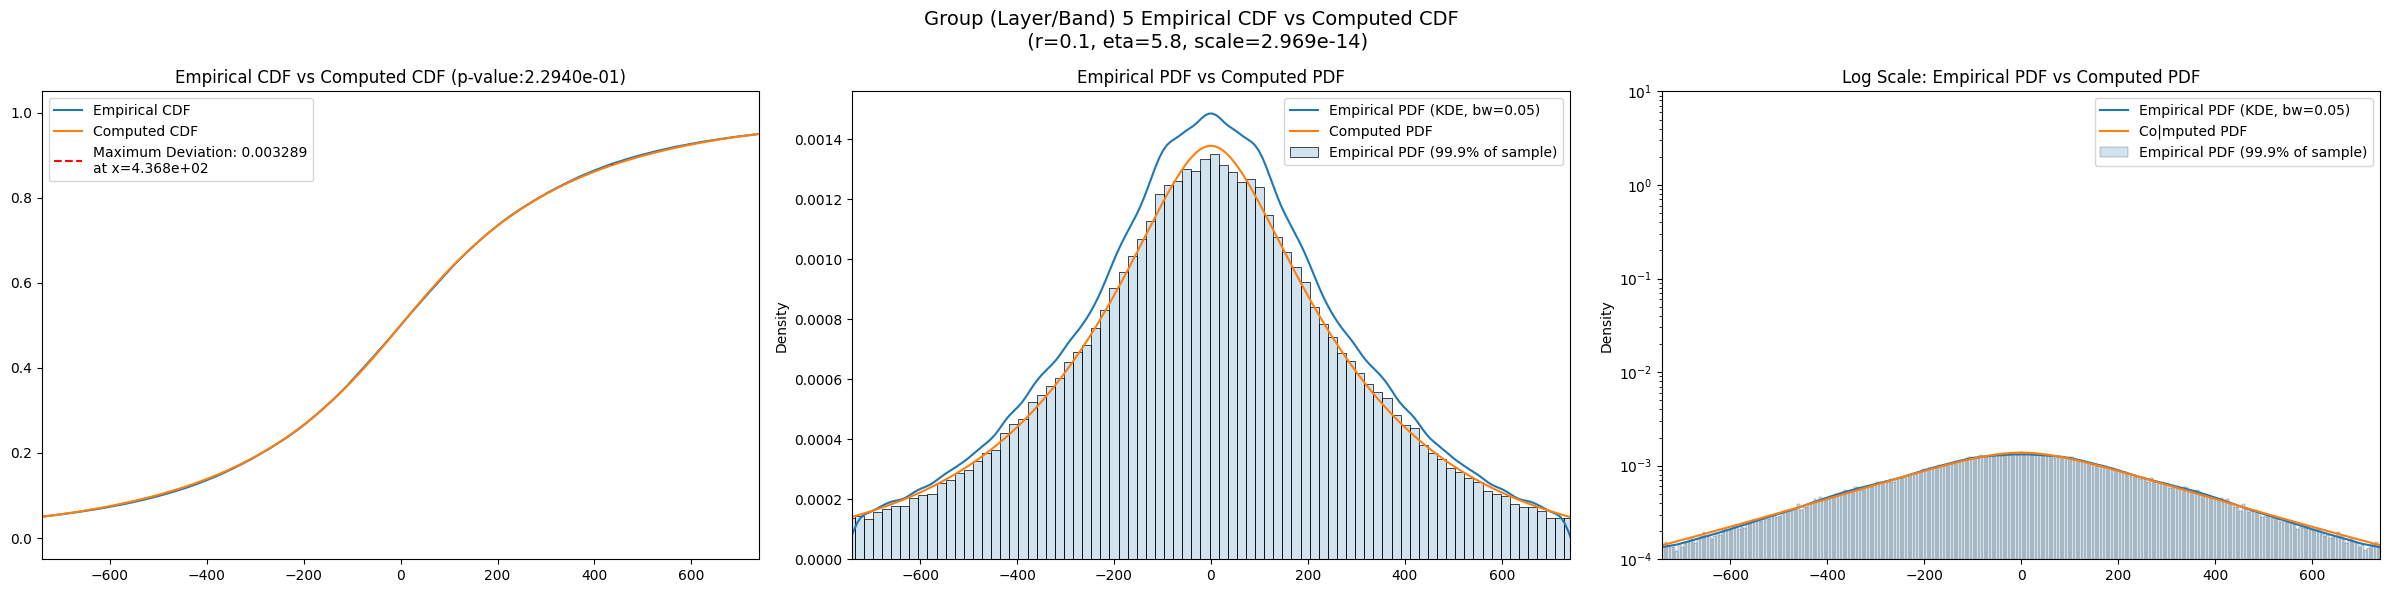

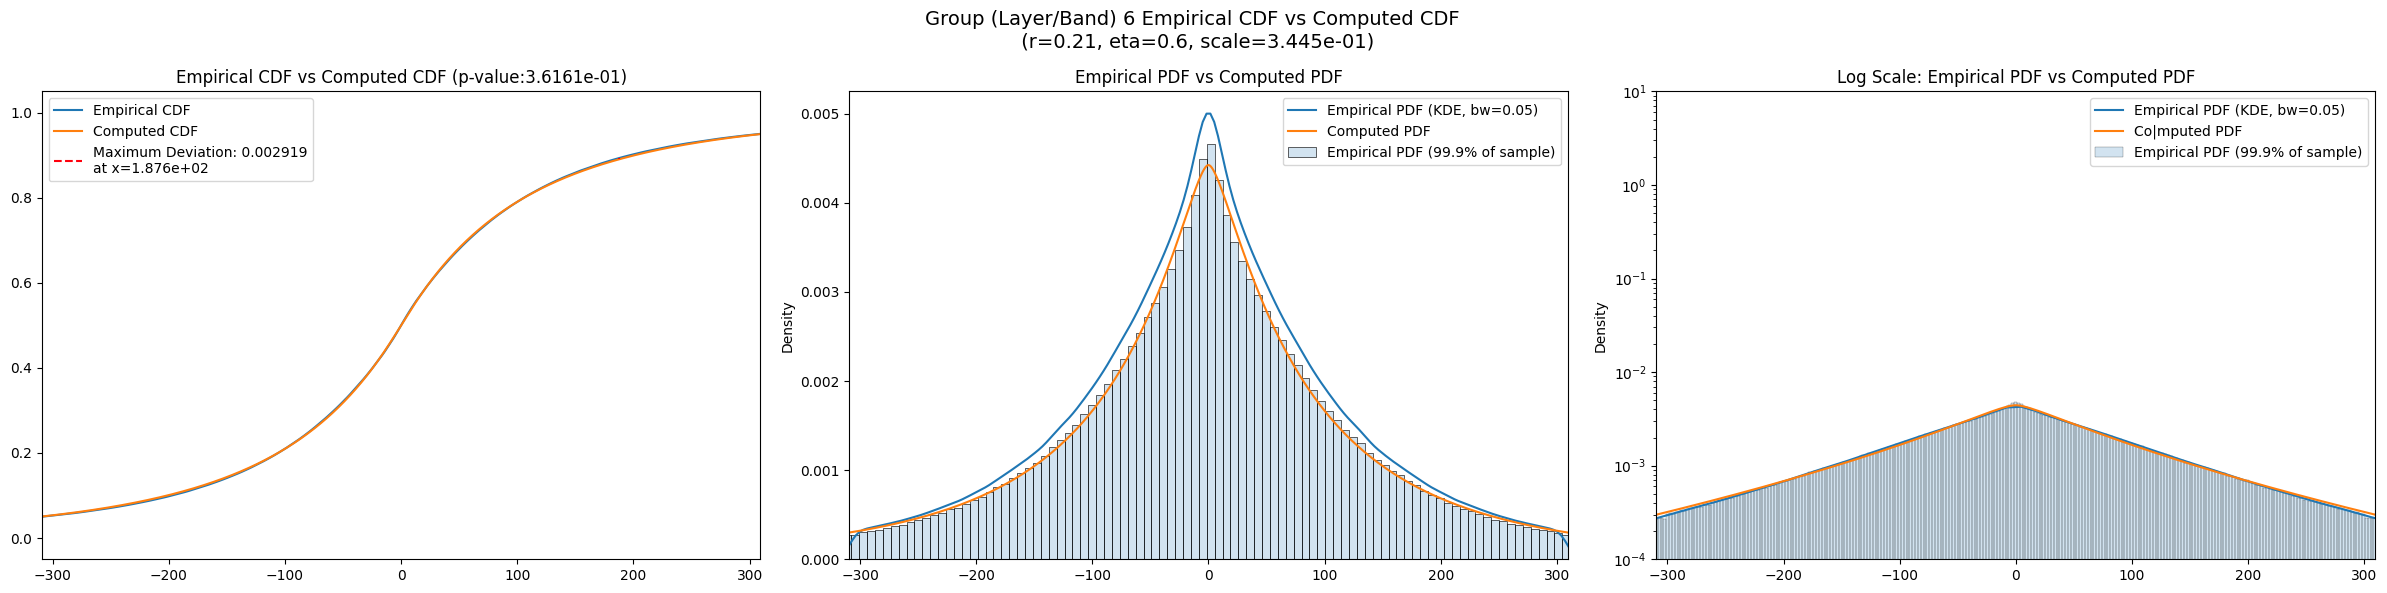

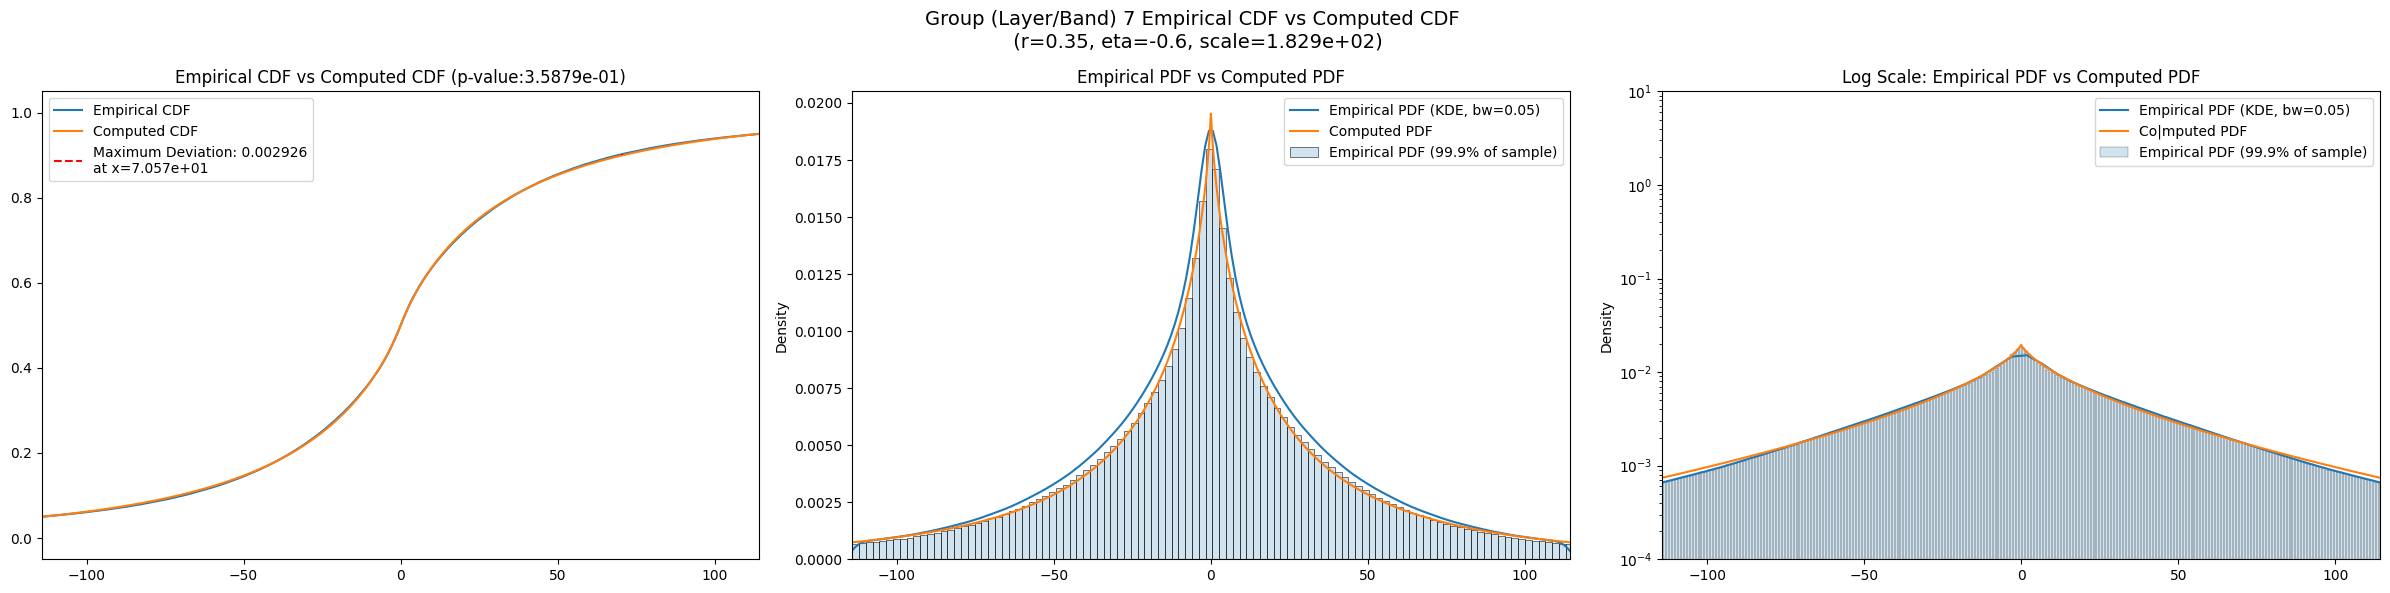

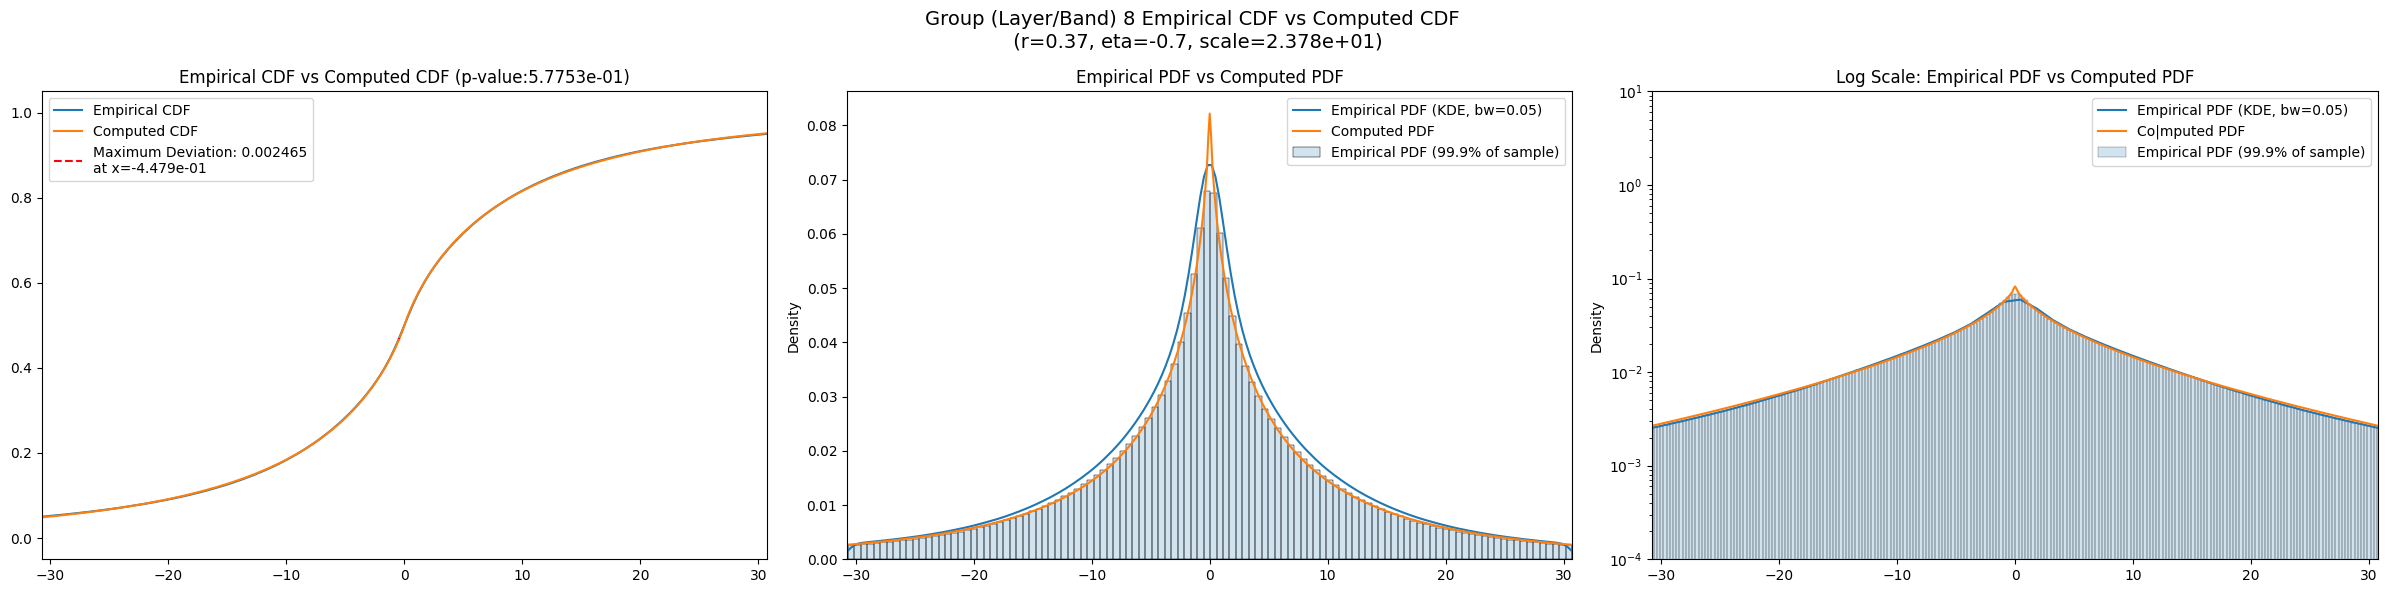

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2               NaN           NaN           NaN        NaN         NaN   
3      1.917588e+06  1.678674e+06  2.165048e+06  -0.628360   -0.869535   
4      8.142820e+05  7.775826e+05  8.514975e+05   1.116847    0.878992   
5      2.493660e+05  2.319150e+05  2.677669e+05   5.788045    4.961286   
6      4.386916e+04  4.057316e+04  4.733290e+04   6.932356    5.826878   
7      6.100906e+03  5.614957e+03  6.619654e+03   8.188866    6.884765   
8      4.320266e+02  3.940085e+02  4.756335e+02  11.321023    7.565761   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            0.0                  NaN        NaN          NaN   
3       -0.348175          564.0             0.053007        1.0         20.0   
4        1.405564        22538.0             0.016901        0.6          0.5   
5        6.675331       296776.0             0.003516        0.1          5.7   
6        8.281218      2880648.0             0.003102        0.2          0.7   
7        9.728744     25362406.0             0.003786        0.4         -0.7   
8       25.109600    213093688.0             0.003225        0.3         -0.5   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...             NaN                   NaN                   NaN   
3      ...       1561.3400              0.037350          4.011390e-01   
4      ...        761.2370              0.034607          6.903270e-24   
5      ...        368.4950              0.028389         3.250790e-208   
6      ...        138.2480              0.038216          0.000000e+00   
7      ...         44.7125              0.049132          0.000000e+00   
8      ...         11.5502              0.053099          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2                NaN                  NaN                  NaN         NaN   
3          1393.9900             0.061673         2.624170e-02  1143.55000   
4           673.6510             0.010084         2.029700e-02   555.07200   
5           320.0300             0.007186         9.711000e-14   263.75700   
6           123.0860             0.012939         0.000000e+00    96.64200   
7            39.2247             0.023421         0.000000e+00    30.62840   
8            10.1091             0.026689         0.000000e+00     7.92454   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2                NaN            NaN                   NaN  
3           0.057539       0.045912          8.145911e-02  
4           0.017056       0.000004          5.061721e-06  
5           0.004450       0.000016          1.396037e-03  
6           0.011601       0.000000          1.346390e-19  
7           0.024586       0.000000         1.442737e-216  
8           0.027607       0.000000          0.000000e+00  

[7 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                      NaN                      NaN               NaN   
3                 0.053007                 0.056882          0.052968   
4                 0.016901                 0.009039          0.016901   
5                 0.003516                 0.002492          0.003499   
6                 0.003102                 0.000800          0.002768   
7                 0.003786                 0.000270          0.003132   
8                 0.003225                 0.000093          0.002490   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                       NaN                  NaN            NaN  
3                  0.037350             0.061673       0.057539  
4                  0.034607             0.010084       0.017056  
5                  0.028389             0.007186       0.004450  
6                  0.038216             0.012939       0.011601  
7                  0.049132             0.023421       0.024586  
8                  0.053099             0.026689       0.027607

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2                     NaN               NaN     NaN       NaN           NaN   
3            1.917588e+06          0.052968    1.02      20.0  9.662094e+04   
4            8.142820e+05          0.016901    0.60       0.5  9.425852e+04   
5            2.305042e+05          0.003499    0.10       5.8  2.969260e-14   
6            4.386916e+04          0.002768    0.21       0.6  3.445065e-01   
7            6.100906e+03          0.003132    0.35      -0.6  1.829277e+02   
8            4.320266e+02          0.002490    0.37      -0.7  2.377625e+01   

       best_exclude_cutoff  
layer                       
2                      NaN  
3                      0.0  
4                      0.0  
5                    125.0  
6                      0.0  
7                      0.0  
8                      0.0

In [21]:
eng.quit()